In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
import tensorflow as tf
tf.set_random_seed(0)

In [4]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((-1, 1))
y_train = y_train.astype(np.float32).reshape((-1, 1))

In [5]:
from edward.models import Normal

In [6]:
W_0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

In [7]:
x = x_train
intermed1 = tf.tanh(tf.matmul(x, W_0) + b_0)
intermed2 = tf.matmul(intermed1, W_1) + b_1
y = Normal(loc=intermed2, scale=0.1)

In [8]:
qW_0 = Normal(
    loc=tf.Variable(tf.zeros([1, 2])),
    scale=tf.nn.softplus(tf.Variable(tf.zeros([1, 2]))))
qW_1 = Normal(
    loc=tf.Variable(tf.zeros([2, 1])),
    scale=tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))
qb_0 = Normal(
    loc=tf.Variable(tf.zeros(2)),
    scale=tf.nn.softplus(tf.Variable(tf.zeros(2))))
qb_1 = Normal(
    loc=tf.Variable(tf.zeros(1)),
    scale=tf.nn.softplus(tf.Variable(tf.zeros(1))))

In [9]:
W_0, W_1, b_0, b_1, qW_0, qW_1, qb_0, qb_1

(<ed.RandomVariable 'Normal/' shape=(1, 2) dtype=float32>,
 <ed.RandomVariable 'Normal_1/' shape=(2, 1) dtype=float32>,
 <ed.RandomVariable 'Normal_2/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'Normal_3/' shape=(1,) dtype=float32>,
 <ed.RandomVariable 'Normal_5/' shape=(1, 2) dtype=float32>,
 <ed.RandomVariable 'Normal_6/' shape=(2, 1) dtype=float32>,
 <ed.RandomVariable 'Normal_7/' shape=(2,) dtype=float32>,
 <ed.RandomVariable 'Normal_8/' shape=(1,) dtype=float32>)

In [10]:
import edward as ed

In [11]:
inference = ed.KLqp(
    latent_vars = {
        W_0: qW_0,
        b_0: qb_0,
        W_1: qW_1,
        b_1: qb_1,
    },
    data = {y: y_train})

In [12]:
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 5s | Loss: -9.721


In [13]:
y_sample = y.sample(3).eval()

In [14]:
y_sample.shape

(3, 50, 1)

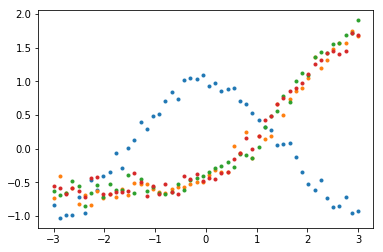

In [15]:
fig, ax = plt.subplots()
ax.plot(x_train, y_train, '.')
ax.plot(x_train, y_sample[0], '.');
ax.plot(x_train, y_sample[1], '.');
ax.plot(x_train, y_sample[2], '.');

In [16]:
foo = qW_0.sample([10000]).eval()

In [17]:
qW_0.loc.eval(), qW_0.scale.eval()

(array([[-1.04196334, -0.98095566]], dtype=float32),
 array([[ 0.02284634,  0.02296495]], dtype=float32))

In [18]:
foo.mean(axis=0), foo.std(axis=0)

(array([[-1.04216707, -0.98103827]], dtype=float32),
 array([[ 0.02318598,  0.02300849]], dtype=float32))

In [19]:
ops = tf.get_default_graph().get_operations()

In [20]:
len(ops)

1206

In [21]:
shapes = []
tensor_sizes = []
for op in ops:
    for f in op.outputs:
        try:
            shape = f.shape.as_list()
        except ValueError as e:
            shape = None
        shapes.append(shape)
        if shape is not None and not np.array_equal([None], shape):
            tensor_sizes.append(int(np.prod(shape)))
        else:
            tensor_sizes.append(np.nan)

In [22]:
np.nanmax(tensor_sizes)

20000.0